In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import plotly.express as px
plt.style.use(['science','ieee', 'no-latex']) # set the style of the plots

from util import *

In [4]:
adult = pd.read_parquet('data/formatted_data.parquet')
adult.drop(columns=['fnlwgt', 'education-num'], inplace=True) # dropping these columns
train = adult[adult['set'] == 'train'].drop(columns=['set'])
test = adult[adult['set'] == 'test'].drop(columns=['set'])
print(f'Train shape: {train.shape}')
display(train.head())
print(f'Test shape: {test.shape}')
display(test.head())

Train shape: (32561, 13)


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


Test shape: (16281, 13)


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,25,Private,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,Some-college,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


# Data Preprocessing

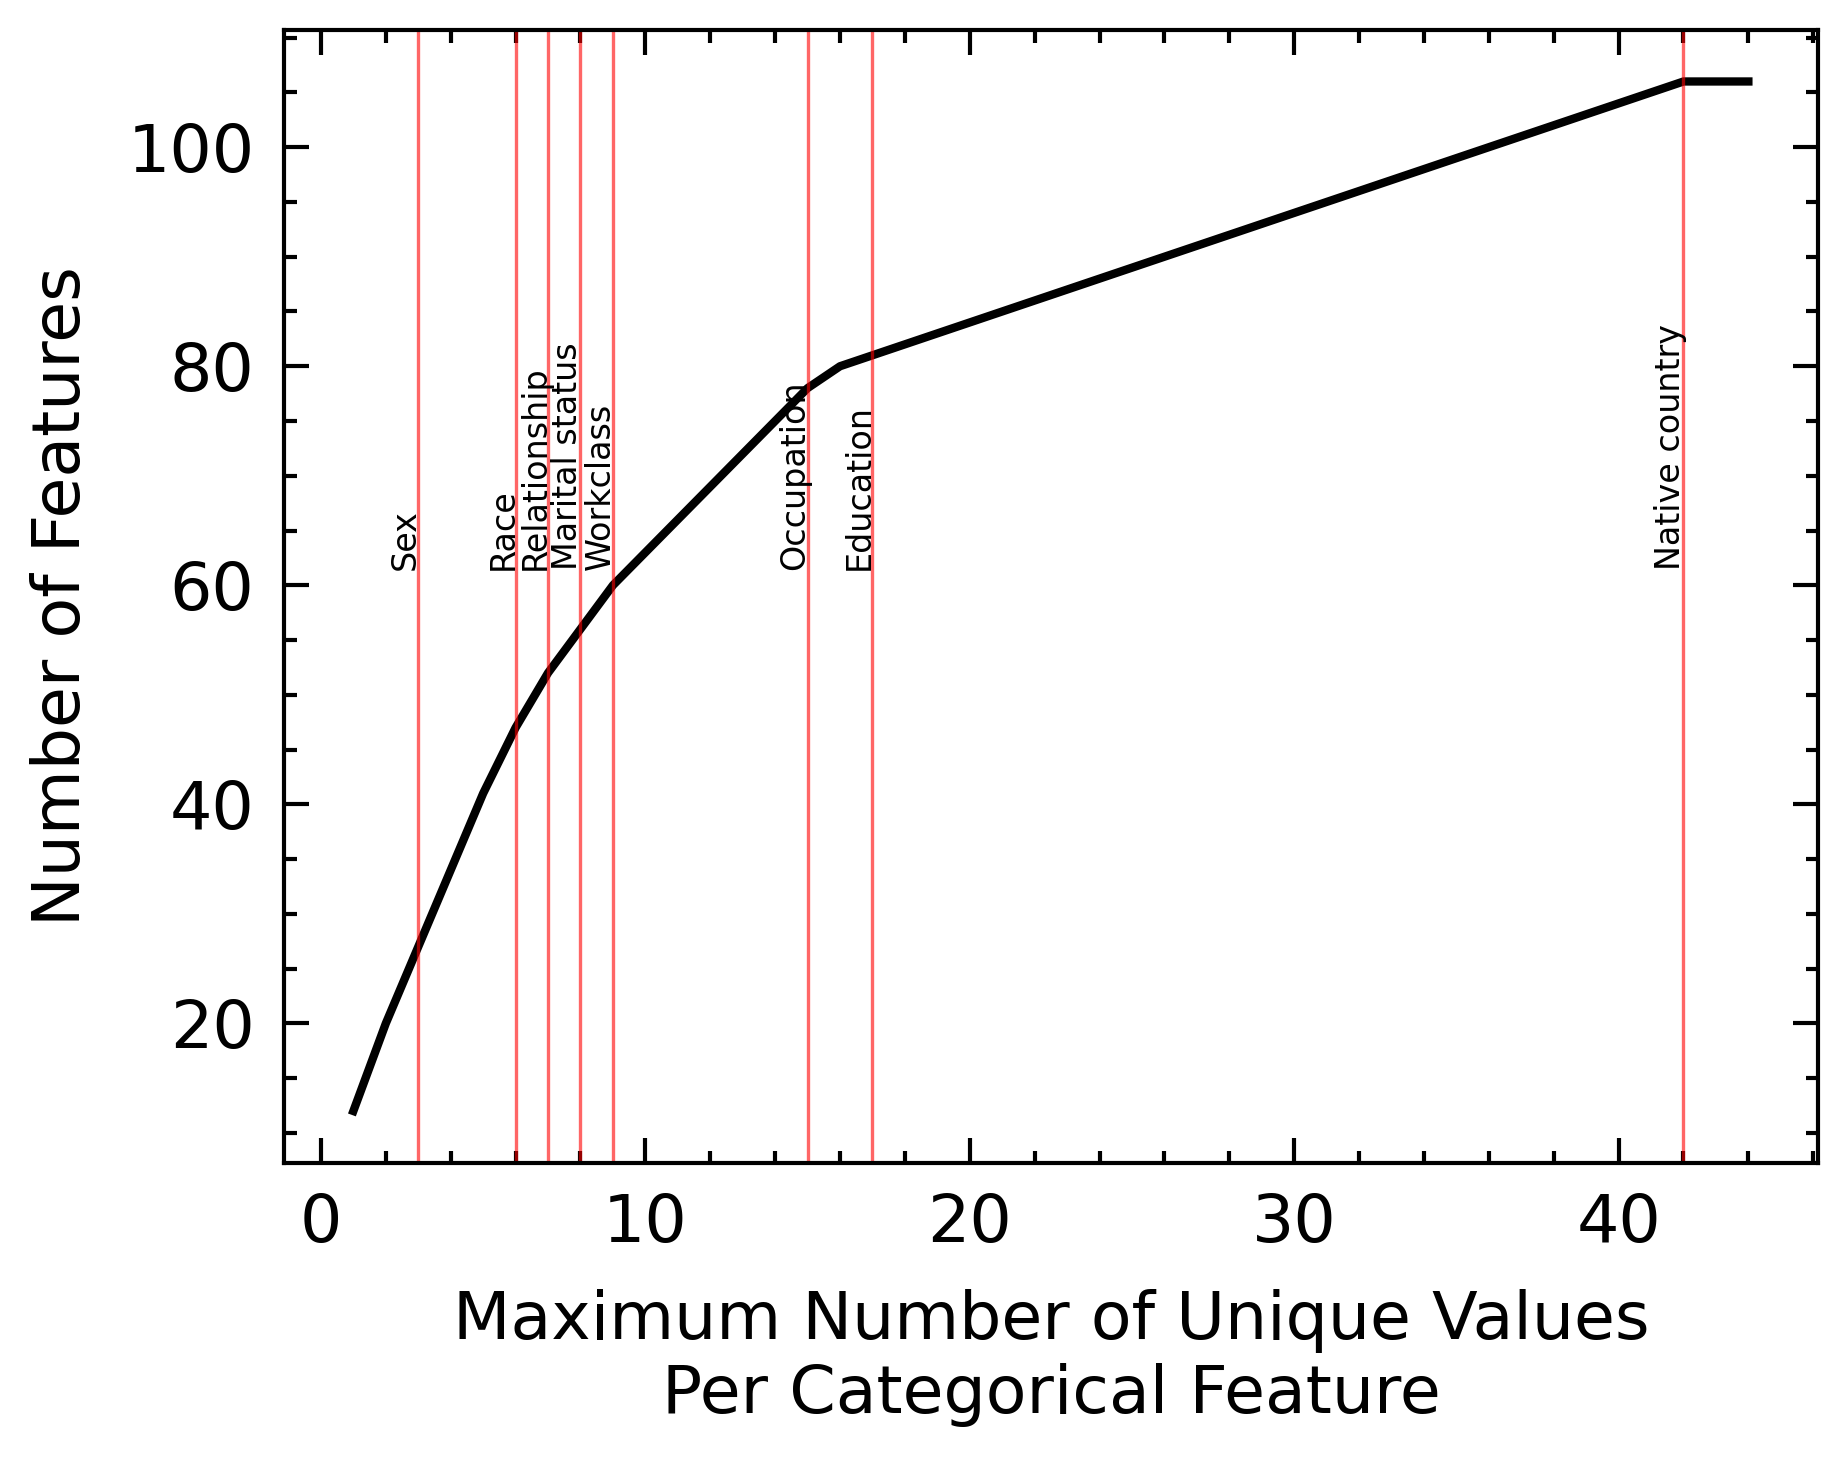

In [10]:
# get the num catgeories vs dimensionality
XTrain = train.drop(columns=['target'])

numCats = []
dims = []

for numCat in range(1, 45):
    XTrainCat = dfCategoryLimit(XTrain, numCat)
    data = getPreprocessor().fit_transform(XTrainCat)
    numCats.append(numCat)
    dims.append(data.shape[1])

# plot the number of categories vs dimensionality
fig, ax = plt.subplots()
ax.plot(numCats, dims)
ax.set_xlabel('Maximum Number of Unique Values\nPer Categorical Feature')
ax.set_ylabel('Number of Features')

for category, size in train.select_dtypes('category').nunique().items():
    if category == 'target':
        continue
    plt.axvline(x=size+1, color='r', linewidth=0.4, alpha=0.6)
    plt.text(size+0.1, 62, category.replace('-', ' ').capitalize(), rotation=90, fontsize=4)
plt.savefig('figures/numCategoryValsVsNumDims.png', bbox_inches='tight')
plt.show()

# Fitting The Model

In [6]:
def runLogisticRegression(XTrainTrans, YTrain, n_iter, max_iter):    
    clf = RandomizedSearchCV(
        estimator=LogisticRegression(max_iter=max_iter, solver='saga'),
        param_distributions={
            'C': np.logspace(-4, 4, 9),
            'penalty':  ['elasticnet', 'l1', 'l2', 'none'],
            'l1_ratio': np.linspace(0, 1, 11), # for elasticnet
        },
        scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
        refit='roc_auc',
        n_iter=n_iter,
        cv=4,
        n_jobs=-1
        )
    return clf.fit(XTrainTrans, YTrain)

In [7]:
# collect data
# 30 iterations 0f 4-fold cross validation for each number of maximum values per categorical feature

results = []

for numCat in [3, 5, 10, 20, 42]:
    print(f'Starting {numCat} categories')
    train_ = dfCategoryLimit(train, numCat) # limit the number values per category
    XTrain, YTrain, XTest, YTest = XYSplit(train_, test) # split into X and Y
    XTrain, YTrain = donwSampleLabels(XTrain, YTrain) # downsample the labels

    preprocessor = getPreprocessor().fit(XTrain) # fit the preprocessor
    XTrainTrans = preprocessor.transform(XTrain) # transform the training data
    XTestTrans = preprocessor.transform(XTest) # transform the test data

    nDims = XTrainTrans.shape[1] # get the number of dimensions
    print(f'Starting Search for {numCat} categories')
    search = runLogisticRegression(XTrainTrans, YTrain, n_iter=30, max_iter=300) # run the logistic regression search
    testMetrics = getMetrics(search, XTestTrans, YTest) # get the test metrics
    cvResults = search.cv_results_ # get the cross validation results
    results.append((numCat, nDims, testMetrics, cvResults, search)) # collect the results
pd.DataFrame(results, columns=['numCat', 'nDims', 'testMetrics', 'cvResults', 'searchObj']).to_pickle('data/logistic_results.pkl')

Starting 3 categories
Starting Search for 3 categories


c:\Users\brady\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Starting 5 categories
Starting Search for 5 categories
Starting 10 categories
Starting Search for 10 categories


c:\Users\brady\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Starting 20 categories
Starting Search for 20 categories


c:\Users\brady\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


Starting 42 categories
Starting Search for 42 categories


c:\Users\brady\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
c:\Users\brady\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [8]:
results = pd.read_pickle('data/results.pkl')
results

,numCat,nDims,testMetrics,cvResults,searchObj
0,3,27,"{'accuracy': 0.7454087586757571, 'precision': ...","{'mean_fit_time': [0.2797587513923645, 5.07718...","RandomizedSearchCV(cv=4,\n e..."
1,5,41,"{'accuracy': 0.7374239911553344, 'precision': ...","{'mean_fit_time': [0.08277642726898193, 6.4789...","RandomizedSearchCV(cv=4,\n e..."
2,10,63,"{'accuracy': 0.7941158405503348, 'precision': ...","{'mean_fit_time': [8.497323393821716, 0.046505...","RandomizedSearchCV(cv=4,\n e..."
3,20,84,"{'accuracy': 0.8041275105951723, 'precision': ...","{'mean_fit_time': [3.4044178128242493, 3.99724...","RandomizedSearchCV(cv=4,\n e..."
4,42,105,"{'accuracy': 0.8052330937903077, 'precision': ...","{'mean_fit_time': [4.049373686313629, 4.179760...","RandomizedSearchCV(cv=4,\n e..."
